
# Computadora B — Modelado (Lab ML P7: ¡Atrapa el mejor modelo!)

Este cuaderno implementa **la parte de modelación** indicada para la Computadora B, siguiendo la guía del laboratorio:
- Entrena **modelos base** (no-ensambles) con `scikit-learn`: Regresión Logística, Árbol de Decisión, KNN y SVM.
- Implementa **tres votadores desde cero** (sin `VotingClassifier`): **votación dura**, **votación suave** y **votación ponderada** (por exactitud en validación).
- Reporta métricas y curvas simples de desempeño.
- Genera un **archivo de predicciones** para el conjunto de prueba en el **formato** solicitado.



## 0) Rutas y parámetros principales


In [ ]:
from pathlib import Path

DATASET_TRAIN_CSV = Path("train.csv")  
DATASET_TEST_CSV  = Path("test.csv")   

TEAM_NAME  = "Charmander"
VOTER_NAME = "VotacionPonderada"  

RANDOM_STATE = 42


In [3]:
import pandas as pd

RANDOM_STATE = 42
df = pd.read_csv('..\data\dataset.csv', index_col=0)

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
C:\Users\luke2\AppData\Local\Temp\ipykernel_23468\3138752179.py:4: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv('..\data\dataset.csv', index_col=0)


In [10]:
df.head()

,id,name,height,weight,base_experience,hp,attack,defense,special_attack,special_defense,speed,primary_type,secondary_type,num_abilities,abilities,power_score,strong
0,250,ho-oh,38,1990,306,106,130,90,110,154,90,fire,flying,2,"pressure, regenerator",680,1
1,434,stunky,4,192,66,63,63,47,41,41,74,poison,dark,3,"stench, aftermath, keen-eye",329,0
2,20,raticate,7,185,145,55,81,60,50,70,97,normal,NaN,3,"run-away, guts, hustle",413,0
3,323,camerupt,19,2200,161,70,100,70,105,75,40,fire,ground,3,"magma-armor, solid-rock, anger-point",460,0
4,333,swablu,4,12,62,45,40,60,40,75,50,normal,flying,2,"natural-cure, cloud-nine",310,0


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df,test_size=0.2, random_state=RANDOM_STATE)
print(train.shape, test.shape)

train.to_csv('train.csv')
test.to_csv('test.csv')

(400, 16) (100, 16)



## 1) Carga y preparación de datos

- Seleccionamos **features permitidos** por la consigna.
- Codificamos la **categoría** `primary_type` con One-Hot.
- Escalamos las variables numéricas.
- Partimos en `train/valid` para estimar pesos del votador ponderado.


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df = pd.read_csv(DATASET_TRAIN_CSV)

feature_cols = ["height", "weight", "base_experience", "primary_type"]
target_col   = "strong"

missing_cols = [c for c in feature_cols + [target_col] if c not in df.columns]
if missing_cols:
    raise ValueError(f"Faltan columnas en el dataset de entrenamiento: {missing_cols}")

X = df[feature_cols].copy()
y = df[target_col].astype(int).copy()
id_col = "id" if "id" in df.columns else None

num_cols  = ["height", "weight", "base_experience"]
cat_cols  = ["primary_type"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Tamaños -> Train:", X_train.shape, "Valid:", X_valid.shape)


Tamaños -> Train: (320, 4) Valid: (80, 4)



## 2) Modelos base

Entrenaremos cuatro modelos individuales (no-ensambles):
- **Regresión Logística**
- **Árbol de Decisión**
- **KNN**
- **SVM** (con `probability=True` para **votación suave** y **ponderada**)



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

logreg_params = dict(C=1.0, max_iter=200)
tree_params   = dict(max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=RANDOM_STATE)
knn_params    = dict(n_neighbors=15, weights="distance") 
svm_params    = dict(C=1.0, kernel="rbf", probability=True, random_state=RANDOM_STATE)

models = {
    "logreg": Pipeline([("prep", preprocess), ("clf", LogisticRegression(**logreg_params))]),
    "tree":   Pipeline([("prep", preprocess), ("clf", DecisionTreeClassifier(**tree_params))]),
    "knn":    Pipeline([("prep", preprocess), ("clf", KNeighborsClassifier(**knn_params))]),
    "svm":    Pipeline([("prep", preprocess), ("clf", SVC(**svm_params))]),
}

# Entrenamiento
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
print("Modelos entrenados.")


Modelos entrenados.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def eval_binary(y_true, y_pred):
    return dict(
        accuracy = accuracy_score(y_true, y_pred),
        precision= precision_score(y_true, y_pred, zero_division=0),
        recall   = recall_score(y_true, y_pred, zero_division=0),
        f1       = f1_score(y_true, y_pred, zero_division=0),
    )

import pandas as pd
metrics_rows = []
preds_valid = {}
proba_valid = {}

for name, pipe in models.items():
    yp = pipe.predict(X_valid)
    preds_valid[name] = yp
    metrics = eval_binary(y_valid, yp)
    metrics_rows.append({"model": name, **metrics})
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        proba_valid[name] = pipe.predict_proba(X_valid)[:, 1]
    else:
        proba_valid[name] = yp.astype(float)

metrics_df = pd.DataFrame(metrics_rows).sort_values("accuracy", ascending=False).reset_index(drop=True)
metrics_df


,model,accuracy,precision,recall,f1
0,tree,0.9375,0.857143,0.90,0.878049
1,knn,0.9375,0.941176,0.80,0.864865
2,logreg,0.9250,0.937500,0.75,0.833333
3,svm,0.9000,0.833333,0.75,0.789474


In [26]:
proba_valid

{'logreg': array([7.20979457e-04, 1.24357870e-01, 9.47829158e-01, 3.65737543e-02,
        5.75652522e-03, 2.43347164e-01, 1.43365424e-03, 9.27062182e-04,
        1.82271127e-03, 9.76337685e-01, 4.18386008e-01, 2.59328122e-01,
        2.11384316e-03, 1.05713991e-03, 7.53854417e-02, 9.00691579e-01,
        1.91416548e-01, 4.12233779e-01, 9.96617089e-01, 1.68778133e-03,
        1.86642541e-03, 2.38818747e-02, 8.75102636e-01, 1.83359879e-03,
        8.47573457e-01, 5.27407725e-03, 1.74219511e-03, 2.49113935e-01,
        9.97130983e-02, 1.66990678e-02, 3.78008257e-01, 3.10049933e-01,
        5.09621530e-03, 2.03589886e-03, 6.71837274e-01, 1.19464699e-01,
        3.29788577e-01, 9.54769838e-01, 2.32769012e-03, 2.93902186e-03,
        4.62877817e-01, 9.64176999e-01, 9.78402245e-01, 5.31221113e-03,
        9.72036150e-01, 1.95880428e-01, 1.82693935e-01, 5.38329036e-03,
        2.25855968e-03, 1.87884492e-03, 2.81557196e-03, 3.82330838e-02,
        2.94430892e-03, 5.65372147e-02, 9.99202104e-01


## 3) Ensambles de votación (desde cero)

Se implementan funciones puras para:
- **Votación dura**: mayoría sobre predicciones 0/1.
- **Votación suave**: promedio de probabilidades `P(y=1|x)` y umbral 0.5.
- **Votación ponderada**: promedio ponderado de probabilidades usando pesos ∝ exactitud en validación de cada modelo.


In [ ]:
import numpy as np

def vote_hard(pred_dict):
    base = list(pred_dict.values())
    stacked = np.vstack(base).astype(int)
    votes = stacked.sum(axis=0)
    yhat  = (votes > (stacked.shape[0] / 2)).astype(int)
    return yhat

def vote_soft(proba_dict):
    base = list(proba_dict.values())
    stacked = np.vstack(base)  
    avg = stacked.mean(axis=0)
    return (avg >= 0.5).astype(int), avg

def vote_weighted(proba_dict, weights):
    keys = list(proba_dict.keys())
    w = np.array([weights[k] for k in keys], dtype=float)
    w = w / (w.sum() + 1e-12)
    stacked = np.vstack([proba_dict[k] for k in keys])  
    wavg = (w[:, None] * stacked).sum(axis=0)
    return (wavg >= 0.5).astype(int), wavg

# Pesos proporcionales a la exactitud en validación
accs = {row["model"]: row["accuracy"] for _, row in metrics_df.iterrows()}
accs


{'tree': 0.9375, 'knn': 0.9375, 'logreg': 0.925, 'svm': 0.9}


## 4) Evaluación en validación

Se muestran métricas: exactitud, precisión, recall y F1. Además, se grafica la matriz de confusión por votador.


In [24]:
preds_valid

{'logreg': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]),
 'tree': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]),
 'knn': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]),
 'svm': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0

### Métricas de votadores (validación)

,voter,accuracy,precision,recall,f1
0,soft,0.9375,0.857143,0.9,0.878049
1,weighted,0.9375,0.857143,0.9,0.878049
2,hard,0.9125,0.933333,0.7,0.800000


<Figure size 640x480 with 0 Axes>

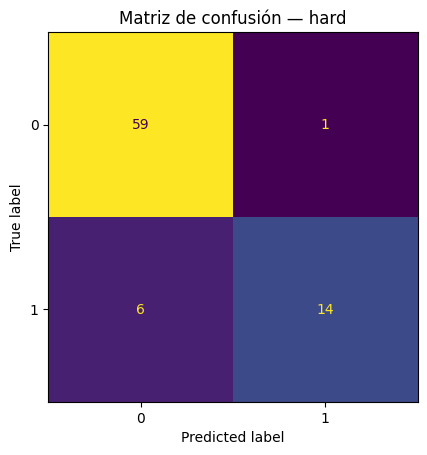

<Figure size 640x480 with 0 Axes>

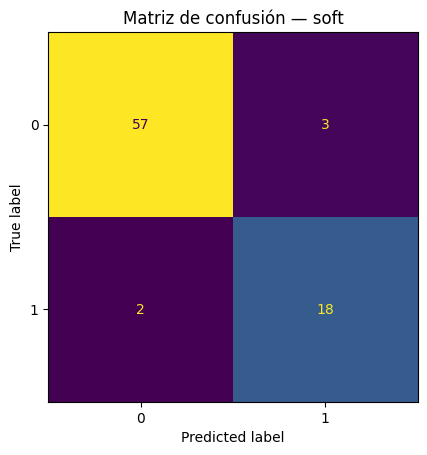

<Figure size 640x480 with 0 Axes>

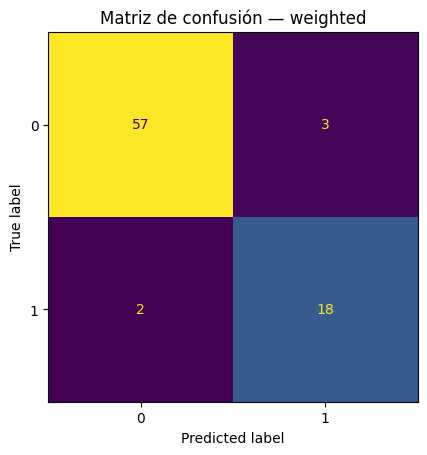

,voter,accuracy,precision,recall,f1
0,soft,0.9375,0.857143,0.9,0.878049
1,weighted,0.9375,0.857143,0.9,0.878049
2,hard,0.9125,0.933333,0.7,0.800000


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

yhat_hard = vote_hard(preds_valid)
m_hard = eval_binary(y_valid, yhat_hard)

yhat_soft, soft_scores = vote_soft(proba_valid)
m_soft = eval_binary(y_valid, yhat_soft)

yhat_w, w_scores = vote_weighted(proba_valid, accs)
m_w = eval_binary(y_valid, yhat_w)

ens_metrics = pd.DataFrame([
    {"voter":"hard", **m_hard},
    {"voter":"soft", **m_soft},
    {"voter":"weighted", **m_w},
]).sort_values("accuracy", ascending=False).reset_index(drop=True)

from IPython.display import display, Markdown

display(Markdown("### Métricas de votadores (validación)"))
display(ens_metrics)


for voter_name, yhat in [("hard", yhat_hard), ("soft", yhat_soft), ("weighted", yhat_w)]:
    cm = confusion_matrix(y_valid, yhat)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure()
    disp.plot(values_format='d', colorbar=False)  
    plt.title(f"Matriz de confusión — {voter_name}")
    plt.show()

ens_metrics


In [35]:
ens_metrics

,voter,accuracy,precision,recall,f1
0,soft,0.9375,0.857143,0.9,0.878049
1,weighted,0.9375,0.857143,0.9,0.878049
2,hard,0.9125,0.933333,0.7,0.800000


In [27]:
print(ens_metrics)

      voter  accuracy  precision  recall        f1
0      soft    0.9375   0.857143     0.9  0.878049
1  weighted    0.9375   0.857143     0.9  0.878049
2      hard    0.9125   0.933333     0.7  0.800000



## 5) Reentrenar en todo el set de entrenamiento

Tras seleccionar el votador final, reentrenamos cada modelo base en **todo el train** (train+valid) para aprovechar al máximo los datos.


In [ ]:
for name, pipe in models.items():
    pipe.fit(X, y)
print("Modelos reentrenados en todo el dataset de entrenamiento.")


Modelos reentrenados en todo el dataset de entrenamiento.



## 6) Predicción sobre el test set y archivo de competencia

Generamos el archivo:  
`id,y_pred,EquipoNombre,VotacionTipo` en la primera fila y las filas siguientes solo con `id,y_pred`.

Cambia `TEAM_NAME` y `VOTER_NAME` según tu equipo y tu votador elegido.


In [ ]:
test_df = pd.read_csv(DATASET_TEST_CSV)

test_id_col = "id" if "id" in test_df.columns else None
if test_id_col is None:
    test_ids = np.arange(len(test_df))
else:
    test_ids = test_df[test_id_col].values

missing_cols_test = [c for c in ["height","weight","base_experience","primary_type"] if c not in test_df.columns]
if missing_cols_test:
    raise ValueError(f"Faltan columnas en el dataset de test: {missing_cols_test}")

X_test = test_df[["height","weight","base_experience","primary_type"]].copy()

preds_test = {}
proba_test = {}
for name, pipe in models.items():
    yp = pipe.predict(X_test)
    preds_test[name] = yp
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        proba_test[name] = pipe.predict_proba(X_test)[:, 1]
    else:
        proba_test[name] = yp.astype(float)

VOTER_NAME = VOTER_NAME.strip()

if VOTER_NAME.lower() == "votaciondura":
    y_pred_final = vote_hard(preds_test)
elif VOTER_NAME.lower() == "votacionsuave":
    y_pred_final, _ = vote_soft(proba_test)
elif VOTER_NAME.lower() == "votacionponderada":
    y_pred_final, _ = vote_weighted(proba_test, accs)
else:
    raise ValueError("VOTER_NAME inválido. Usa: VotacionDura, VotacionSuave o VotacionPonderada")

# Archivo de competencia
import csv
out_path = Path("predicciones_competencia.csv")
with open(out_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["id", "y_pred", TEAM_NAME, VOTER_NAME])
    for i, (rid, yhat) in enumerate(zip(test_ids, y_pred_final)):
        writer.writerow([rid, int(yhat), "", ""])

print(f"Archivo de competencia escrito en: {out_path}")
out_path


Archivo de competencia escrito en: predicciones_competencia.csv


WindowsPath('predicciones_competencia.csv')

In [23]:
output = pd.read_csv("predicciones_competencia.csv")
output.head()

,id,y_pred,Charmander,VotacionPonderada
0,362,1,NaN,NaN
1,74,0,NaN,NaN
2,375,0,NaN,NaN
3,156,0,NaN,NaN
4,105,0,NaN,NaN
